In [1]:
%load_ext autoreload
%autoreload 2

# Plotting

`poligrain` shall make your live easier when plotting data as points, lines and grids. In particular plotting lines from CML paths using a colormap will be easy now.

Since we enforce a fixed naming convention of site cooridnates in the `xarray.Dataset`s that we use, we do not have to fiddle with these during plotting. We can just take the `Dataset`s as input for our plotting functions.

In [2]:
import matplotlib.pyplot as plt
import xarray as xr

import poligrain as plg

## Plot CML paths 

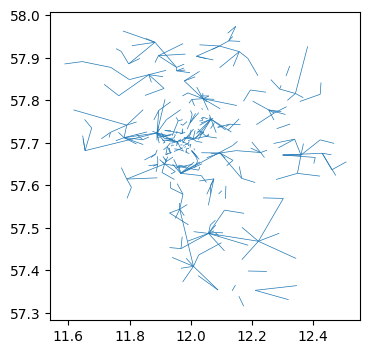

In [3]:
ds_cmls = xr.open_dataset("../../tests/test_data/openMRG_CML_180minutes.nc")

fig, ax = plt.subplots(figsize=(4, 4))
plg.plot_map.plot_lines(ds_cmls, linewidth=0.5, ax=ax);

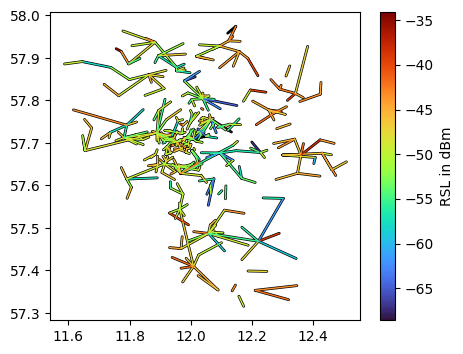

In [4]:
ds_cmls = xr.open_dataset("../../tests/test_data/openMRG_CML_180minutes.nc")

fig, ax = plt.subplots(figsize=(5, 4))
lines = plg.plot_map.plot_lines(
    ds_cmls.rsl.isel(sublink_id=0).isel(time=100), linewidth=1, ax=ax
)
plt.colorbar(lines, label="RSL in dBm");